In [1]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
from agent import DQN

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir = save_path / "6-24-EW"
data_dir.exists()

True

In [5]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [6]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

### Loading Model

In [7]:
model_path = data_dir / 'trained-agent-state-7.pt'
model_path.exists()

True

In [8]:
parameters = data_dict['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [9]:
model = DQN(n_observations, n_actions, n_units)
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [10]:
state_dict = model.state_dict()

layer0_weights = state_dict['mlp.0.weight']
layer1_weights = state_dict['mlp.1.weight']
layer2_weights = state_dict['mlp.3.weight']
layer3_weights = state_dict['mlp.5.weight']
layer4_weights = state_dict['mlp.7.weight']

weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]
print(len(weights))

5


In [11]:
print(len(weights))
print(weights[0].shape)
print(weights[1].shape)
print(weights[4].shape)

5
torch.Size([512, 21])
torch.Size([512, 512])
torch.Size([3, 512])


## Q-Values Over Time

In [ ]:
# epsilon_warmup = 100
# after 100 episodes the agent starts to have probability to choose best Q-value actions

%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

all_q_values = data_dict['all_qvalues']

run = 6
episodes = all_q_values[run]

def plot_episode(episode):
    plt.figure(figsize=(8,4))
    plt.plot(episodes[episode], label=['Move Forward','Turn Left','Turn Right'])
    plt.title(f"Episode {episode}", fontsize=20)
    plt.legend()
    plt.xlabel('Step', fontsize=15)
    plt.ylabel('Q-Value', fontsize=15)
    plt.show()

interact(plot_episode, episode=(0, len(episodes)-1));

# concatenate all the plots of steps

interactive(children=(IntSlider(value=99, description='episode', max=199), Output()), _dom_classes=('widget-in…

In [ ]:
# TODO: delineate odor cue as red line during step ;;  look at sharp drops and see what state agent is in
# understand more about DQN

data_dict['all_states'][0][0][30]

## Weight Clustering

### Clustering nodes based on their incoming weight vectors

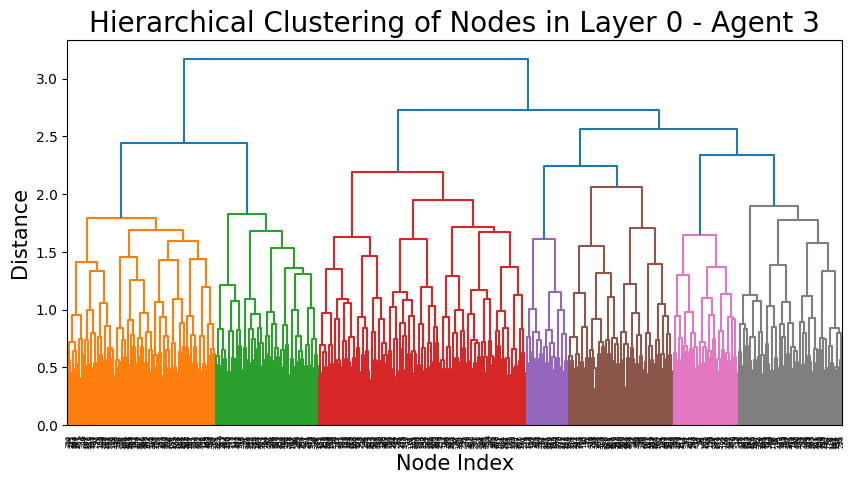

In [65]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# weights comes from the last run
#weights = data_dict['weights']['val']

layer = 0
W = weights[layer].detach().numpy()

# Compute distance matrix (Euclidean is default)
distance_matrix = pdist(W, metric='euclidean')
#print(distance_matrix.shape)

# Perform hierarchical clustering (Ward minimizes variance)
linked = linkage(distance_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title(f"Hierarchical Clustering of Nodes in Layer {layer} - Agent 3", fontsize=20)
plt.xlabel("Node Index", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.savefig('figures/hierclusteringlayer0a3.png', dpi=300)
plt.show()


In [66]:
print(linked.shape)

print('FINAL CLUSTER')
print(linked[510][0])
print(linked[510][1])
print(linked[510][2])
print(linked[510][3])

print('RIGHT CLUSTER ?')
print(linked[509][0])
print(linked[509][1])
print(linked[509][2])
print(linked[509][3])

print('LEFT CLUSTER ?')
print(linked[508][0])
print(linked[508][1])
print(linked[508][2])
print(linked[508][3])

(511, 4)
FINAL CLUSTER
1019.0
1021.0
3.1743168868976217
512.0
RIGHT CLUSTER ?
1016.0
1020.0
2.7294935929512607
346.0
LEFT CLUSTER ?
1017.0
1018.0
2.564300781010506
209.0


In [67]:
def get_cluster_members(Z, cluster_idx, n_leaves):
    """Returns the leaf indices in a cluster"""
    if cluster_idx < n_leaves:
        return [int(cluster_idx)]
    else:
        c1, c2 = int(Z[cluster_idx - n_leaves][0]), int(Z[cluster_idx - n_leaves][1])
        return get_cluster_members(Z, c1, n_leaves) + get_cluster_members(Z, c2, n_leaves)

In [68]:
n = W.shape[0]
cluster_id = 1017
print(get_cluster_members(linked, cluster_id, n))

[6, 314, 133, 159, 35, 151, 356, 321, 480, 89, 411, 54, 371, 121, 390, 220, 339, 258, 193, 250, 304, 77, 470, 238, 331, 114, 113, 226, 108, 312, 33, 417, 212, 434, 224, 251, 260, 24, 115, 60, 15, 71, 430, 325, 278, 83, 102, 348, 166, 184, 3, 310, 398, 420, 168, 363, 103, 405, 210, 367, 233, 256, 440, 496, 269, 383, 465, 188, 473, 406, 27, 344, 48, 302, 459, 99, 10, 230, 486, 505, 117, 281, 112, 279, 357, 336, 365, 100, 502, 34, 185, 441, 416, 451, 303, 263, 426]


In [69]:
first_cluster_id = int(linked[510][0])
second_cluster_id = int(linked[510][1])
print(first_cluster_id)
print(second_cluster_id)

1019
1021


166
346


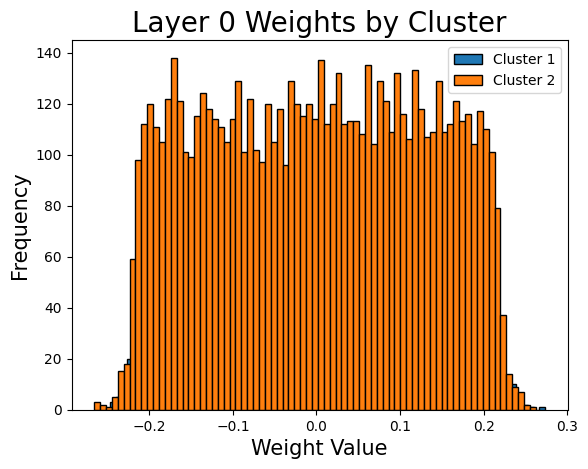

In [70]:
n = W.shape[0]
first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
print(len(first_cluster_nodes))

layer = 0
W = weights[layer].detach().numpy()

cluster_weights = W[first_cluster_nodes]
flat_weights_1 = [item for sublist in cluster_weights for item in sublist]


second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
cluster_weights = W[second_cluster_nodes]
flat_weights_2 = [item for sublist in cluster_weights for item in sublist]
print(len(second_cluster_nodes))


plt.hist(flat_weights_1, bins=75, edgecolor='black', label = 'Cluster 1')
plt.hist(flat_weights_2, bins=75, edgecolor='black', label = 'Cluster 2')
plt.legend()
plt.title('Layer 0 Weights by Cluster', fontsize=20)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Weight Value', fontsize=15)
plt.show()

(512, 21)
166


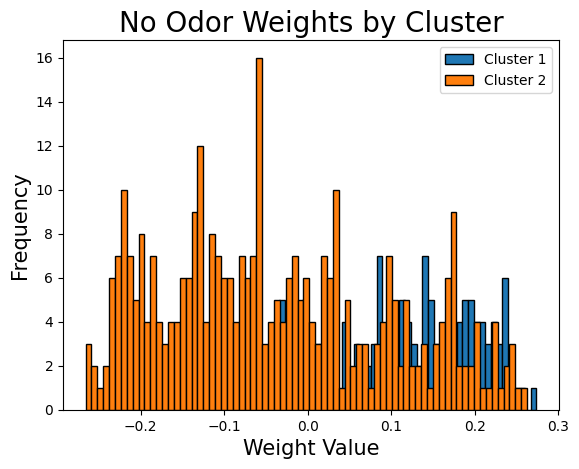

In [71]:
n = W.shape[0]

first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)

layer = 0
W = weights[layer].detach().numpy()
print(W.shape)

cluster_weights = W[first_cluster_nodes]
no_odor_weights_1 = [sublist[0] for sublist in cluster_weights]
print(len(no_odor_weights_1))

second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
cluster_weights = W[second_cluster_nodes]
no_odor_weights_2 = [sublist[0] for sublist in cluster_weights]


plt.hist(no_odor_weights_1, bins=75, edgecolor='black', label = 'Cluster 1')
plt.hist(no_odor_weights_2, bins=75, edgecolor='black', label = 'Cluster 2')
plt.legend()
plt.title('No Odor Weights by Cluster', fontsize=20)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Weight Value', fontsize=15)
plt.show()

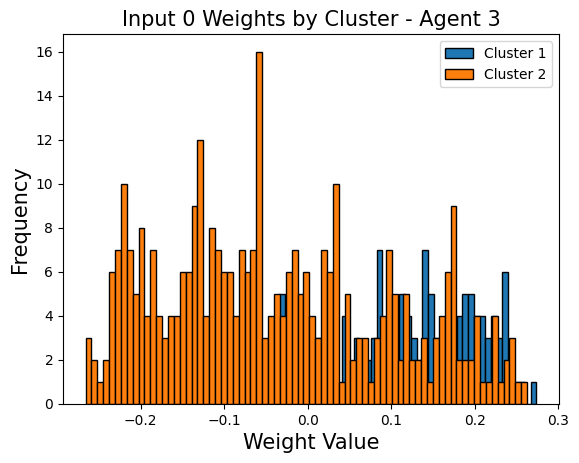

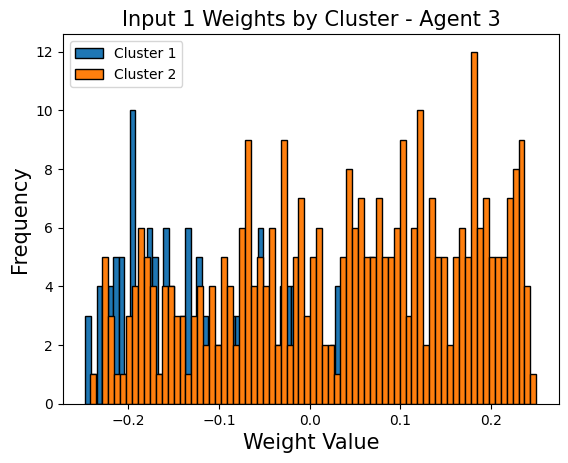

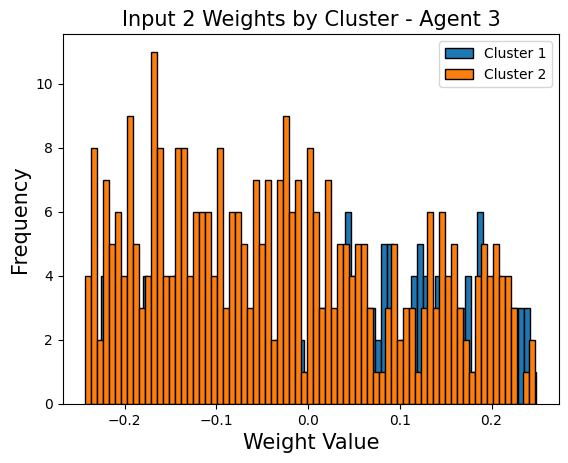

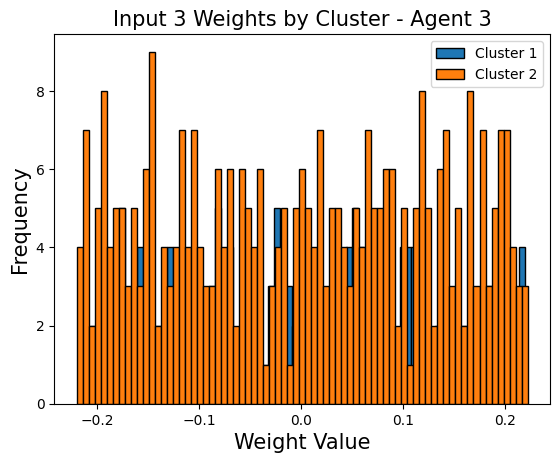

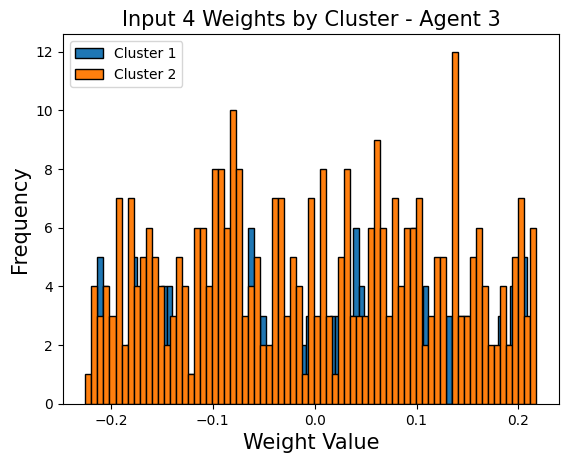

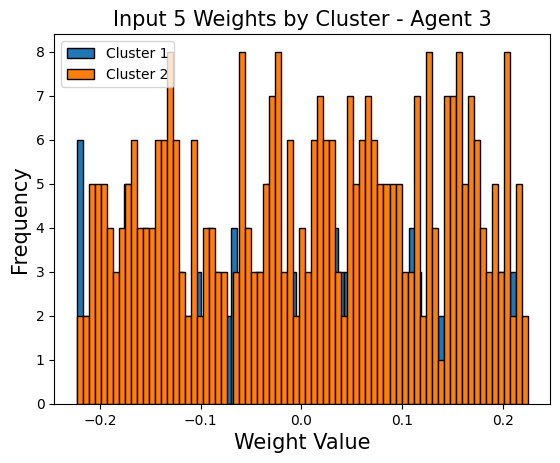

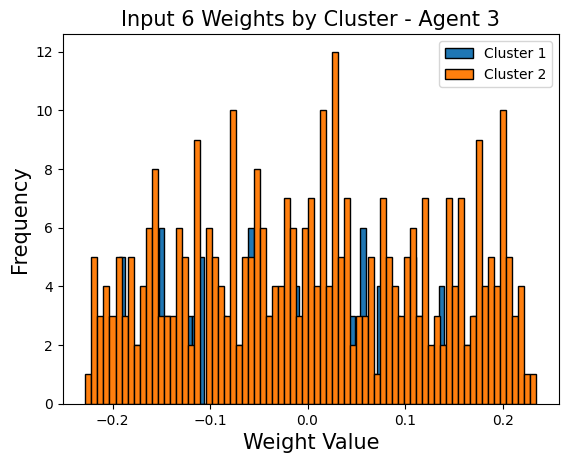

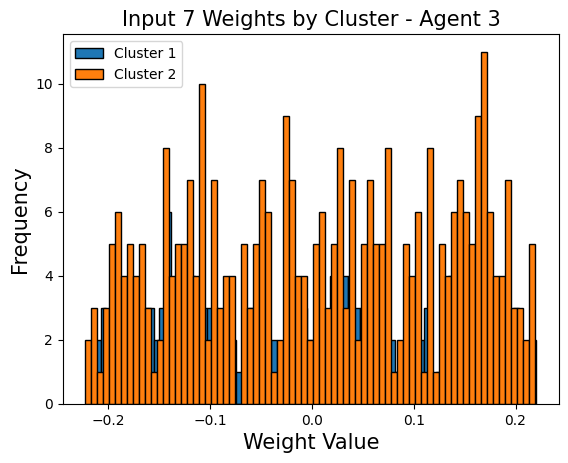

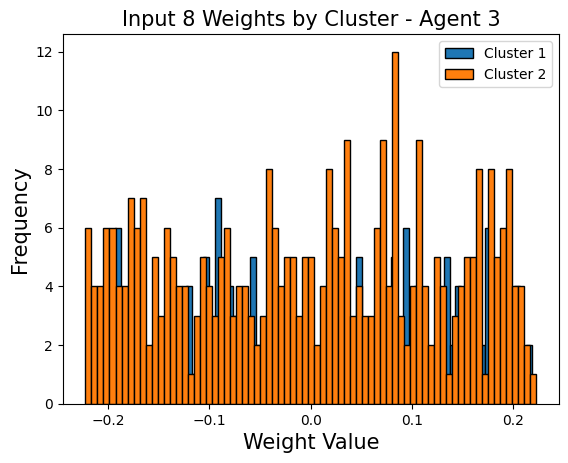

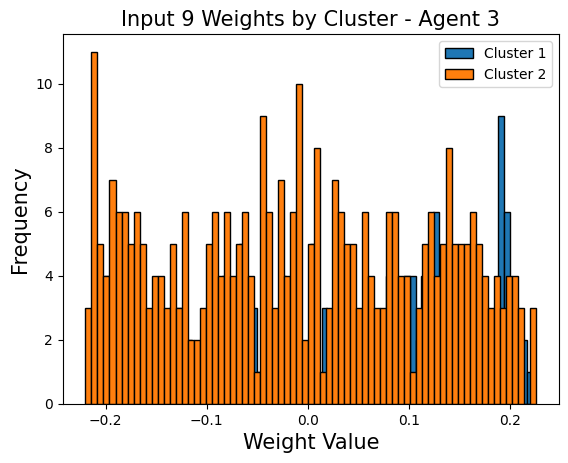

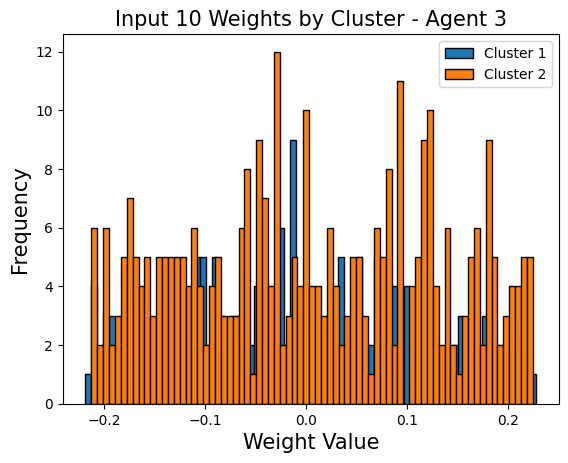

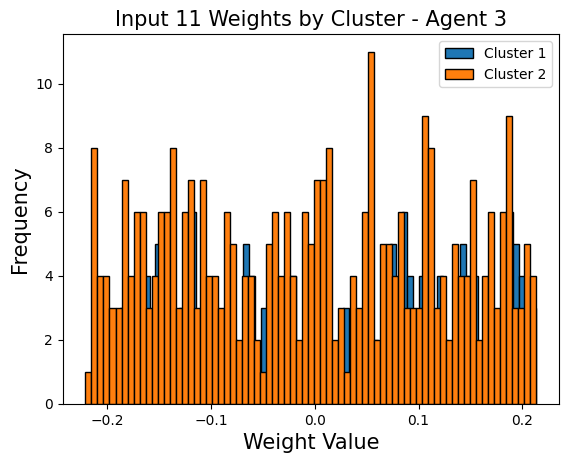

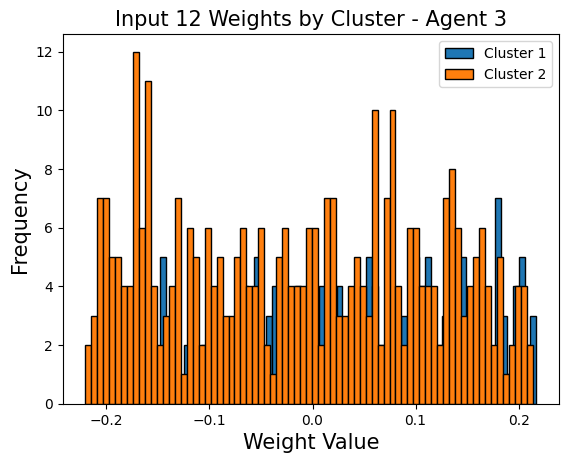

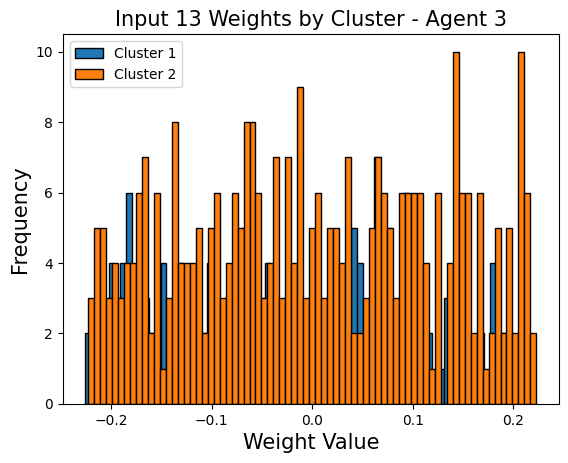

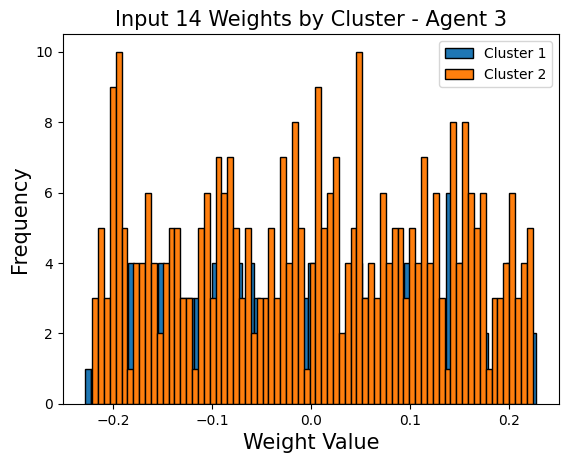

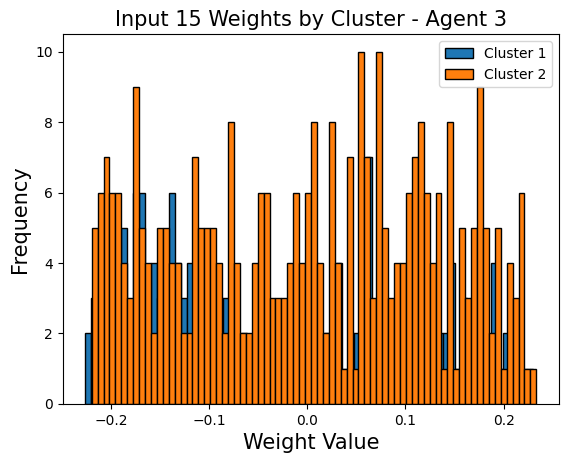

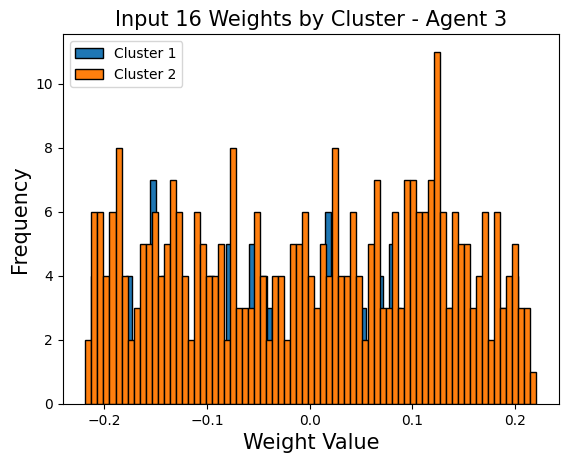

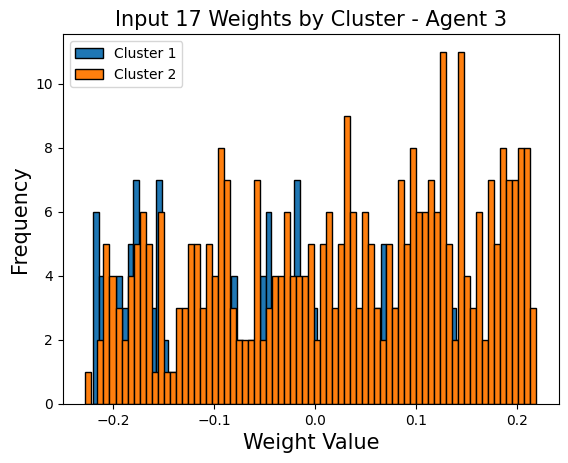

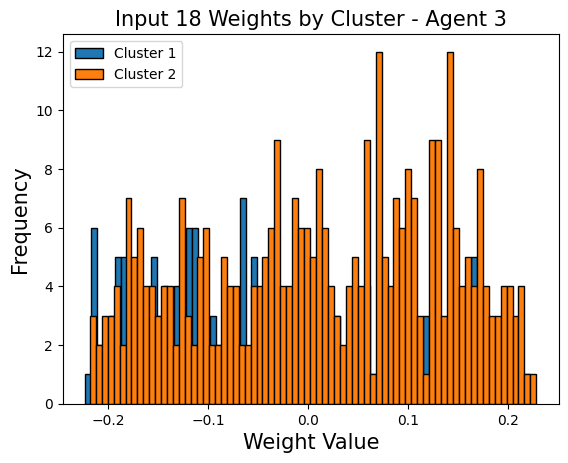

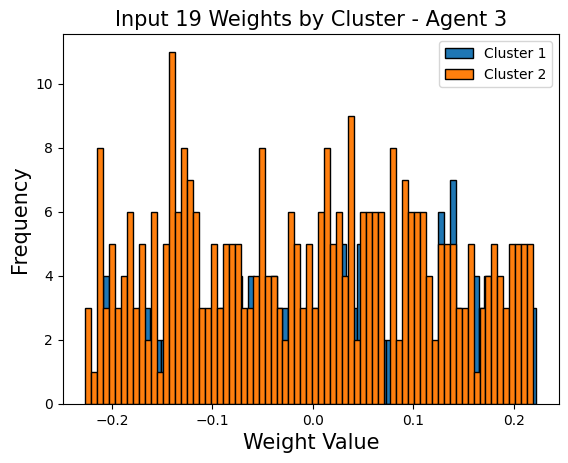

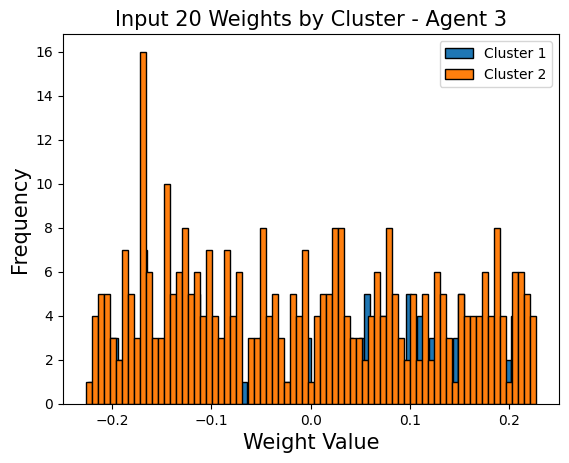

In [72]:
layer = 0
W = weights[layer].detach().numpy()
n = W.shape[0]
for i in range(W.shape[1]):
    
    
    first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
    cluster_weights = W[first_cluster_nodes]
    cluster_1_weights = [sublist[i] for sublist in cluster_weights]

    
    second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
    cluster_weights = W[second_cluster_nodes]
    cluster_2_weights = [sublist[i] for sublist in cluster_weights]


    plt.hist(cluster_1_weights, bins=75, edgecolor='black', label = 'Cluster 1')
    plt.hist(cluster_2_weights, bins=75, edgecolor='black', label = 'Cluster 2')
    plt.legend()
    plt.title(f'Input {i} Weights by Cluster - Agent 3', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.xlabel('Weight Value', fontsize=15)
    plt.savefig(f'figures/input{i}weightsclustera3.png', dpi=500)
    plt.show()


### Clustering Nodes Based on Outgoing Weight - Last Layer

(512, 3)
[-0.03285152  0.03669603 -0.03564593]


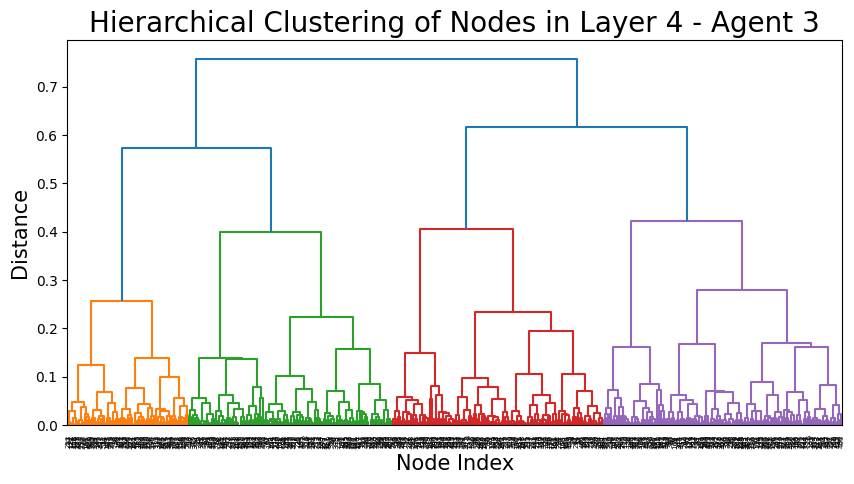

In [113]:
layer = 4
W = weights[layer].detach().numpy().T
print(W.shape)
print(W[0])

# Compute distance matrix (Euclidean is default)
distance_matrix = pdist(W, metric='euclidean')
#print(distance_matrix.shape)

# Perform hierarchical clustering (Ward minimizes variance)
linked = linkage(distance_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title(f"Hierarchical Clustering of Nodes in Layer {layer} - Agent 3", fontsize=20)
plt.xlabel("Node Index", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.savefig('figures/hierclusteringlayer4a3.png', dpi=300)
plt.show()


In [114]:
first_cluster_id = int(linked[510][0])
second_cluster_id = int(linked[510][1])
print(first_cluster_id)
print(second_cluster_id)

1020
1021


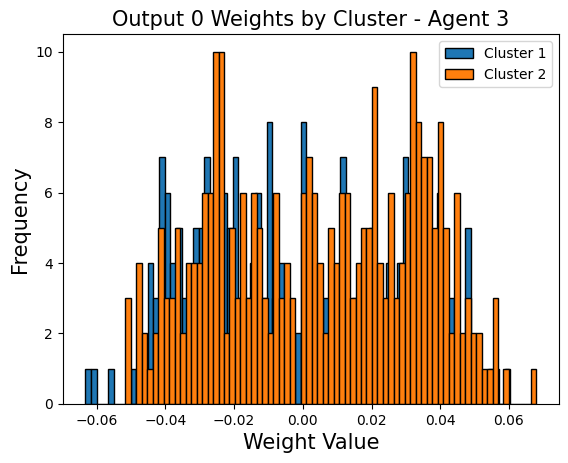

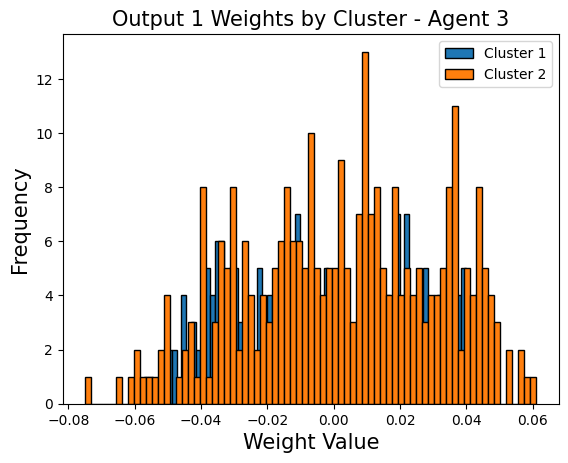

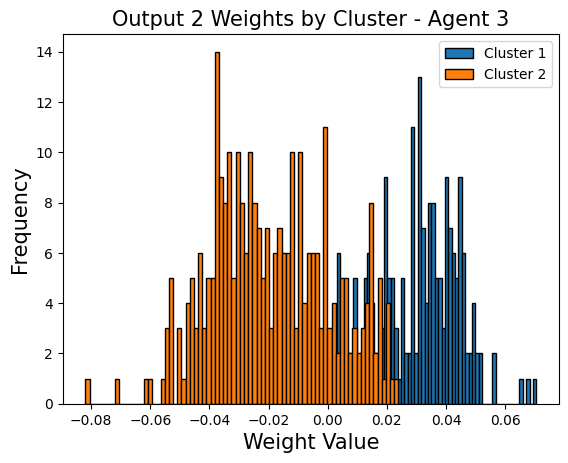

In [117]:
layer = 4
W = weights[layer].detach().numpy().T
n = W.shape[0]
for i in range(W.shape[1]):
    
    
    first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
    cluster_weights = W[first_cluster_nodes]
    cluster_1_weights = [sublist[i] for sublist in cluster_weights]

    
    second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
    cluster_weights = W[second_cluster_nodes]
    cluster_2_weights = [sublist[i] for sublist in cluster_weights]


    plt.hist(cluster_1_weights, bins=75, edgecolor='black', label = 'Cluster 1')
    plt.hist(cluster_2_weights, bins=75, edgecolor='black', label = 'Cluster 2')
    plt.legend()
    plt.title(f'Output {i} Weights by Cluster - Agent 3', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.xlabel('Weight Value', fontsize=15)
    plt.savefig(f'figures/output{i}weightsclustera3.png', dpi=500)
    plt.show()
